# Install requirements

In [1]:
!pip install -r requirements.txt

# Import libraries

In [1]:
from typing import Dict, List, Tuple, Union
import random

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
SEED = 42


def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = False
        
seed_all(SEED)

# Data

In [3]:
data = pd.read_csv("data.txt")
data

,password,strength
0,yrtzuab476,1
1,yEdnN9jc1NgzkkBP,2
2,sarita99,1
3,Suramerica2015,2
4,PPRbMvDIxMQ19TMo,2
...,...,...
99995,aulona044,1
99996,5201314ding,1
99997,isaac19725,1
99998,toji25,0


# EDA

In [4]:
from collections import Counter

def get_char_statistics(passwords) -> Dict[str, int]:
    all_characters = list("".join(passwords.to_list()))
    statistics = dict(sorted(Counter(all_characters).items(), key=lambda x: x[1], reverse=True))
    return statistics


char_statistics = get_char_statistics(data.password)


/Users/user/PycharmProjects/sber-beautifulcode-challenge/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


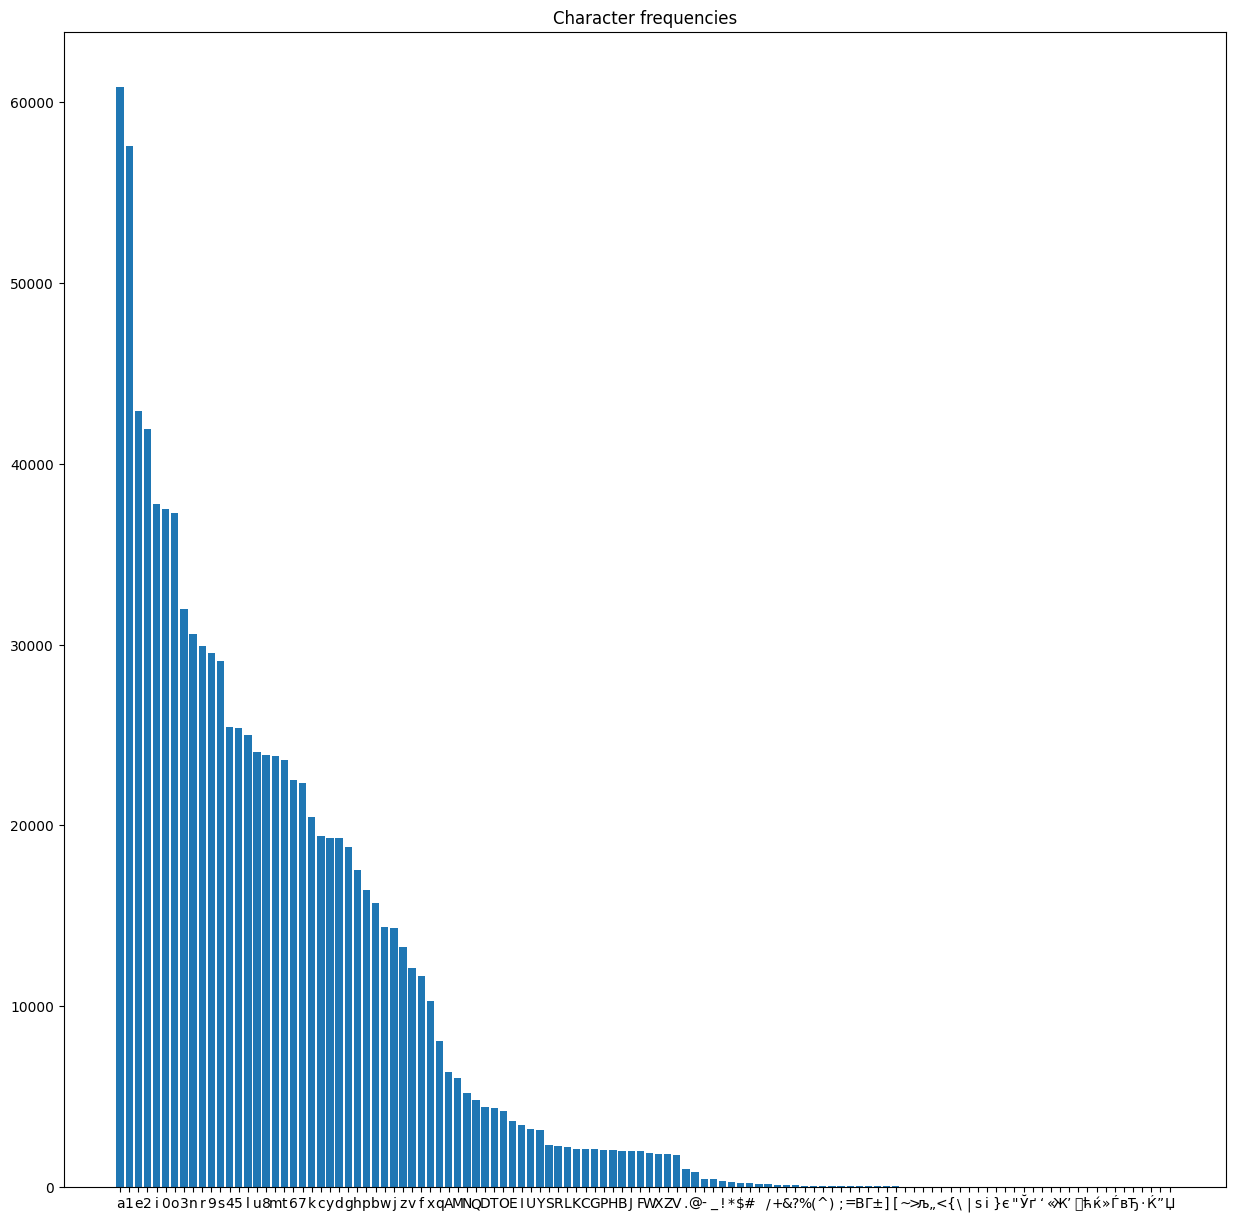

In [5]:
fig, ax = plt.subplots(figsize=(15, 15))

chars = list(char_statistics.keys())
stats = list(char_statistics.values())

ax.bar(chars, stats)
plt.title('Character frequencies')

plt.show()

<Axes: xlabel='strength'>

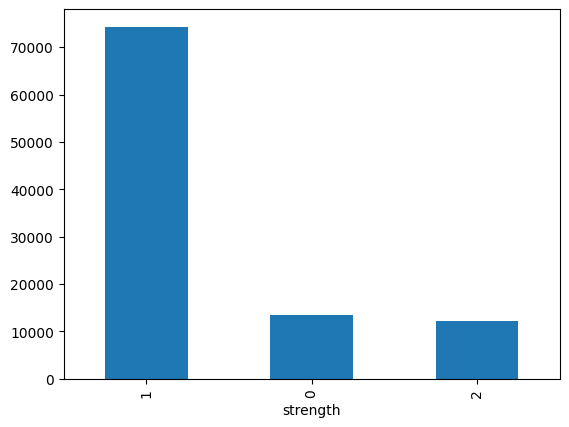

In [6]:
data.strength.value_counts().plot(kind='bar')

/Users/user/PycharmProjects/sber-beautifulcode-challenge/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/user/PycharmProjects/sber-beautifulcode-challenge/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


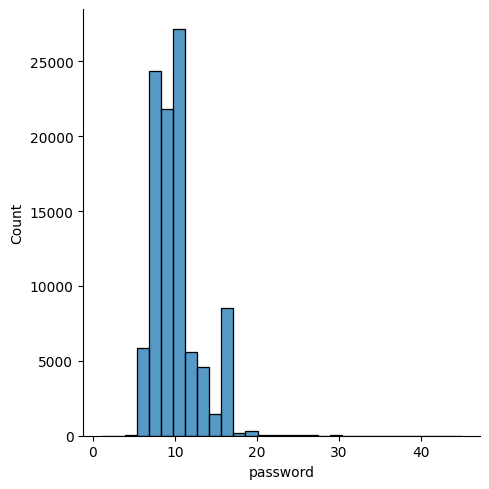

In [7]:
sns.displot(data.password.apply(lambda x: len(x)), bins=30)

# Tokenization

In [8]:
char_to_id = {char: id for id, char in enumerate(list(char_statistics.keys()))}
char_to_id

{'a': 0,
 '1': 1,
 'e': 2,
 '2': 3,
 'i': 4,
 '0': 5,
 'o': 6,
 '3': 7,
 'n': 8,
 'r': 9,
 '9': 10,
 's': 11,
 '4': 12,
 '5': 13,
 'l': 14,
 'u': 15,
 '8': 16,
 'm': 17,
 't': 18,
 '6': 19,
 '7': 20,
 'k': 21,
 'c': 22,
 'y': 23,
 'd': 24,
 'g': 25,
 'h': 26,
 'p': 27,
 'b': 28,
 'w': 29,
 'j': 30,
 'z': 31,
 'v': 32,
 'f': 33,
 'x': 34,
 'q': 35,
 'A': 36,
 'M': 37,
 'N': 38,
 'Q': 39,
 'D': 40,
 'T': 41,
 'O': 42,
 'E': 43,
 'I': 44,
 'U': 45,
 'Y': 46,
 'S': 47,
 'R': 48,
 'L': 49,
 'K': 50,
 'C': 51,
 'G': 52,
 'P': 53,
 'H': 54,
 'B': 55,
 'J': 56,
 'F': 57,
 'W': 58,
 'X': 59,
 'Z': 60,
 'V': 61,
 '.': 62,
 '@': 63,
 '-': 64,
 '_': 65,
 '!': 66,
 '*': 67,
 '$': 68,
 '#': 69,
 ' ': 70,
 '/': 71,
 '+': 72,
 '&': 73,
 '?': 74,
 '%': 75,
 '(': 76,
 '^': 77,
 ')': 78,
 ';': 79,
 '=': 80,
 'В': 81,
 'Г': 82,
 '±': 83,
 ']': 84,
 '[': 85,
 '~': 86,
 '>': 87,
 'љ': 88,
 '„': 89,
 '<': 90,
 '{': 91,
 '\\': 92,
 '|': 93,
 'ѕ': 94,
 'і': 95,
 '}': 96,
 'є': 97,
 '"': 98,
 'Ў': 99,
 'ґ': 100

In [9]:
VOCAB_SIZE = len(list(char_to_id.keys())) + 1 # 116 chars and [PAD]
VOCAB_SIZE

117

In [10]:
MAX_LEN = data.password.apply(lambda x: len(x)).max()

MAX_LEN

45

In [11]:
def get_meta_features(chars):
    letters = 0.0
    numbers = 0.0
    capitals = 0.0
    special_symbols = 0.0
    
    for char in chars:
        if char.isalpha():
            letters += 1
            if char.lower() != char:
                capitals += 1
                
        elif char.isnumeric():
            numbers += 1

        else:
            special_symbols += 1

    return [letters, numbers, capitals, special_symbols]


def preprocess_password(word):
    chars = list(word)
    meta_features = get_meta_features(word)
    ids = [char_to_id[char] for char in chars]
    
    attn_mask = [1 for i in range(len(ids))] + [0 for i in range(MAX_LEN - len(ids))]
    pads = [33] * (MAX_LEN - len(ids))
    ids = ids + pads

    

    return torch.LongTensor(ids).unsqueeze(0), torch.LongTensor(attn_mask).unsqueeze(0), torch.FloatTensor(meta_features).unsqueeze(0)
    

In [12]:
preprocess_password(data.password[0])

(tensor([[23,  9, 18, 31, 15,  0, 28, 12, 20, 19, 33, 33, 33, 33, 33, 33, 33, 33,
          33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
          33, 33, 33, 33, 33, 33, 33, 33, 33]]),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[7., 3., 0., 0.]]))

In [13]:
train_dataset_ids, train_dataset_attn_mask, train_dataset_meta_features = [], [], []

for word in tqdm(data.password):
    sample_ids, sample_attn_mask, meta_feature = preprocess_password(word)
    train_dataset_ids.append(sample_ids)
    train_dataset_attn_mask.append(sample_attn_mask)
    train_dataset_meta_features.append(meta_feature)

train_dataset_ids, train_dataset_attn_mask, train_dataset_meta_features = torch.cat(train_dataset_ids, dim=0), torch.cat(train_dataset_attn_mask, dim=0), torch.cat(train_dataset_meta_features, dim=0)
labels = torch.from_numpy(data.strength.to_numpy())

  0%|          | 0/100000 [00:00<?, ?it/s]

In [14]:
train_dataset_ids

tensor([[23,  9, 18,  ..., 33, 33, 33],
        [23, 43, 24,  ..., 33, 33, 33],
        [11,  0,  9,  ..., 33, 33, 33],
        ...,
        [ 4, 11,  0,  ..., 33, 33, 33],
        [18,  6, 30,  ..., 33, 33, 33],
        [17,  4, 24,  ..., 33, 33, 33]])

In [15]:
dataset = TensorDataset(train_dataset_ids, train_dataset_attn_mask, train_dataset_meta_features, labels)
example_dataloader = DataLoader(dataset, batch_size=64, num_workers=16)

/Users/user/PycharmProjects/sber-beautifulcode-challenge/venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
next(iter(example_dataloader))

[tensor([[23,  9, 18,  ..., 33, 33, 33],
         [23, 43, 24,  ..., 33, 33, 33],
         [11,  0,  9,  ..., 33, 33, 33],
         ...,
         [11, 28, 25,  ..., 33, 33, 33],
         [26,  6, 25,  ..., 33, 33, 33],
         [33,  0,  9,  ..., 33, 33, 33]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[ 7.,  3.,  0.,  0.],
         [14.,  2.,  5.,  0.],
         [ 6.,  2.,  0.,  0.],
         [10.,  4.,  1.,  0.],
         [14.,  2., 10.,  0.],
         [ 4.,  4.,  0.,  0.],
         [ 7.,  1.,  0.,  0.],
         [ 6.,  3.,  0.,  0.],
         [ 7.,  3.,  0.,  0.],
         [ 3.,  6.,  0.,  0.],
         [14.,  2., 10.,  0.],
         [ 8.,  3.,  0.,  0.],
         [ 5.,  2.,  0.,  0.],
         [ 6.,  2.,  6.,  0.],
         [ 6.,  3.,  0.,  0.],
         [12.,  4.,  8.,  0.],
         [ 6.,  

# Model

In [17]:
class AttentionPooling(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()
        
        self.attention = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Linear(d_model, 1),
            nn.ReLU(),
        )
    def forward(self, x, attention_mask):
        attention_scores = torch.softmax(self.attention(x) * attention_mask.unsqueeze(dim=-1), dim=-2)
        x = (x * attention_scores).sum(dim=-2)
        return x


class StrengthLSTM(nn.Module):
    def __init__(self, embedding_dim, num_layers, num_meta_features, output_dim: int = 3, bidirectional: bool = True):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=embedding_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
        )
        
        self.attention_pooling = AttentionPooling(d_model=embedding_dim * (1 + bidirectional))

        self.meta_features_encoder = nn.Sequential(
            nn.BatchNorm1d(num_meta_features),
            nn.Linear(num_meta_features, embedding_dim)
        )
        
        self.out = nn.Linear(embedding_dim * (2 + bidirectional), output_dim)

    def forward(self, input_ids, attention_mask, meta_features):
        x = self.embedding(input_ids)
        x, (h, c) = self.lstm(x)
        
        pooled_x = self.attention_pooling(x, attention_mask)
        meta_x = self.meta_features_encoder(meta_features)
        
        out = self.out(torch.cat([pooled_x, meta_x], dim=-1))
        
        return out

In [18]:
model = StrengthLSTM(
    embedding_dim=64, 
    num_layers=2, 
    num_meta_features=4,
    output_dim=3, 
    bidirectional=True,
)

model

StrengthLSTM(
  (embedding): Embedding(117, 64)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, bidirectional=True)
  (attention_pooling): AttentionPooling(
    (attention): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=128, out_features=1, bias=True)
      (3): ReLU()
    )
  )
  (meta_features_encoder): Sequential(
    (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=4, out_features=64, bias=True)
  )
  (out): Linear(in_features=192, out_features=3, bias=True)
)

In [19]:
example_ids, example_attm_mask, example_meta_features, example_labels = next(iter(example_dataloader))
example_attm_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [20]:
model(example_ids, example_attm_mask, example_meta_features).shape, example_labels.shape

(torch.Size([64, 3]), torch.Size([64]))

# Loops

In [21]:
def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device, n_acum_steps = 1):
    model.to(device)
    model.train()
    total_train_loss = 0

    dl_size = len(data_loader)
    
    preds = []
    targets = []

    batch_i = 0
    for batch in tqdm(data_loader):
        input_ids, attention_masks, meta_features, target = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        meta_features = meta_features.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()        
        logits = model(input_ids, attention_masks, meta_features)
                
        preds.append(logits.argmax(dim=1).detach().cpu())
        targets.append(target.cpu())
                
        loss = loss_function(logits, target) / n_acum_steps
        total_train_loss += loss.item()
        
        loss.backward()
        if batch_i % n_acum_steps == 0 or batch_i == len(data_loader.dataset): 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        batch_i += 1

    preds = torch.cat(preds, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()
    acc = ((targets == preds).sum() / preds.shape[0]).item()
    balanced_acc = balanced_accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")

    metrics = {
        "Train Loss": total_train_loss / dl_size,
        "Train Accuracy": acc,
        "Train Balanced Accuracy": balanced_acc,
        "Train F1": f1,
    }
    
    return metrics
    
    
def eval_epoch(model, data_loader, loss_function, device):
    model.to(device)
    model.eval()
    total_train_loss = 0
    
    preds = []
    targets = []

    dl_size = len(data_loader)

    
    for batch in tqdm(data_loader):
        input_ids, attention_masks, meta_features, target = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        meta_features = meta_features.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            logits = model(input_ids, attention_masks, meta_features)
            preds.append(logits.argmax(dim=1).cpu())
            targets.append(target.cpu())
        
        loss = loss_function(logits, target)
        total_train_loss += loss.item()
            
    preds = torch.cat(preds, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()
    acc = ((targets == preds).sum() / preds.shape[0]).item()
    balanced_acc = balanced_accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")
    # precision = precision_score(targets, preds)
    # recall = recall_score(targets, preds)
    
    metrics = {
        "Eval Loss": total_train_loss / dl_size,
        "Eval Accuracy": acc,
        "Eval Balanced Accuracy": balanced_acc,
        "Eval F1": f1,
    }
    
    return metrics


def single_model(model, 
                 train_dataset, 
                 eval_dataset,  
                 loss_function, 
                 optimizer,
                 get_scheduler,
                 device = torch.device("cuda"),
                 random_state: int = 69, 
                 shuffle: bool = True, 
                 epochs: int = 5, 
                 lr: float = 1e-6,
                 num_workers: int = 1,
                 batch_size: int = 32,
                 n_acum_steps: int = 0):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)

    train_loader = torch.utils.data.DataLoader(
                  train_dataset, 
                  batch_size=batch_size,
                  shuffle=shuffle,
                  num_workers=num_workers
    )

    eval_loader = torch.utils.data.DataLoader(
                  eval_dataset,
                  batch_size=batch_size,
                  shuffle=False,
                  num_workers=num_workers
    )
    
    total_steps = len(train_loader) * epochs 

    scheduler = get_scheduler(optimizer, 
                                        num_warmup_steps = 0, # Default value in run_glue.py
                                        num_training_steps = total_steps)

    for epoch_i in range(0, epochs):
        train_metrics = train_epoch(model, train_loader, loss_function, optimizer, scheduler, device, n_acum_steps)
        eval_metrics = eval_epoch(model, eval_loader, loss_function, device)
        
        print(f"EPOCH: {epoch_i}")
        print(train_metrics)
        print(eval_metrics)


In [22]:
train_inds, eval_inds = train_test_split([i for i in range(len(dataset))], stratify=data.strength, test_size=0.2, random_state=42)
train_dataset = Subset(dataset, indices=train_inds)
eval_dataset = Subset(dataset, indices=eval_inds)

len(train_inds), len(eval_inds)

(80000, 20000)

In [25]:
model = StrengthLSTM(
    embedding_dim=64, 
    num_layers=2,
    num_meta_features=4,
    output_dim=3, 
    bidirectional=True,
)
params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(params_count)

optimizer = torch.optim.AdamW([
    {"params": model.embedding.parameters(), "lr" : 1e-4},
    {"params": model.lstm.parameters(), "lr" : 1e-4},
    {"params": model.out.parameters(), "lr" : 1e-4},
])

get_scheduler = get_cosine_schedule_with_warmup

190924


In [26]:
single_model(
    model=model, 
    train_dataset=train_dataset, 
    eval_dataset=eval_dataset,   
    loss_function=nn.CrossEntropyLoss(), 
    optimizer=optimizer,
    get_scheduler=get_scheduler,
    device=torch.device("cpu"),
    random_state=SEED, 
    shuffle=True, 
    epochs=10, 
    num_workers=0,
    batch_size=128,
    n_acum_steps=1   
)

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 0
{'Train Loss': 0.4857671598434448, 'Train Accuracy': 0.816725, 'Train Balanced Accuracy': 0.5502428745081602, 'Train F1': 0.7744406129156816}
{'Eval Loss': 0.1544755105474952, 'Eval Accuracy': 0.96605, 'Eval Balanced Accuracy': 0.9521875830435039, 'Eval F1': 0.966200213400386}


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 1
{'Train Loss': 0.09508685804009438, 'Train Accuracy': 0.9747625, 'Train Balanced Accuracy': 0.9638801980506901, 'Train F1': 0.9748249629899863}
{'Eval Loss': 0.04873350624493353, 'Eval Accuracy': 0.9886, 'Eval Balanced Accuracy': 0.9822090589976332, 'Eval F1': 0.9886037062921962}


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 2
{'Train Loss': 0.04706059096455574, 'Train Accuracy': 0.9873625, 'Train Balanced Accuracy': 0.9826478475794244, 'Train F1': 0.9873791065273639}
{'Eval Loss': 0.09951784791555374, 'Eval Accuracy': 0.956, 'Eval Balanced Accuracy': 0.9527033934971123, 'Eval F1': 0.956922679694014}


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 3
{'Train Loss': 0.03163894825726748, 'Train Accuracy': 0.9906375, 'Train Balanced Accuracy': 0.9880275136240937, 'Train F1': 0.9906510183815073}
{'Eval Loss': 0.02136268185238075, 'Eval Accuracy': 0.9946, 'Eval Balanced Accuracy': 0.9967060034996683, 'Eval F1': 0.9946239262293253}


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 4
{'Train Loss': 0.023314260164275766, 'Train Accuracy': 0.993325, 'Train Balanced Accuracy': 0.9916553096252572, 'Train F1': 0.993332390297544}
{'Eval Loss': 0.024063835989766913, 'Eval Accuracy': 0.99295, 'Eval Balanced Accuracy': 0.9896194856731048, 'Eval F1': 0.9929545037770396}


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 5
{'Train Loss': 0.01985002791620791, 'Train Accuracy': 0.994175, 'Train Balanced Accuracy': 0.9925153741497753, 'Train F1': 0.9941808921064507}
{'Eval Loss': 0.012882912513699121, 'Eval Accuracy': 0.9969, 'Eval Balanced Accuracy': 0.997749659842987, 'Eval F1': 0.9969078887157522}


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 6
{'Train Loss': 0.014294024329446256, 'Train Accuracy': 0.99645, 'Train Balanced Accuracy': 0.9962698385041685, 'Train F1': 0.9964546618658704}
{'Eval Loss': 0.013074541162657938, 'Eval Accuracy': 0.99675, 'Eval Balanced Accuracy': 0.9976937986276834, 'Eval F1': 0.9967593389706179}


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 7
{'Train Loss': 0.011375114630535244, 'Train Accuracy': 0.997275, 'Train Balanced Accuracy': 0.9973722292744864, 'Train F1': 0.9972788512457215}
{'Eval Loss': 0.012105682069898411, 'Eval Accuracy': 0.99725, 'Eval Balanced Accuracy': 0.998019851105349, 'Eval F1': 0.997256314669803}


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 8
{'Train Loss': 0.010100227188691496, 'Train Accuracy': 0.9976875, 'Train Balanced Accuracy': 0.9979533056273907, 'Train F1': 0.9976905641689933}
{'Eval Loss': 0.010835810523675932, 'Eval Accuracy': 0.9976, 'Eval Balanced Accuracy': 0.9979736027639525, 'Eval F1': 0.9976043262487737}


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

EPOCH: 9
{'Train Loss': 0.009137324153259397, 'Train Accuracy': 0.997975, 'Train Balanced Accuracy': 0.9982094308551818, 'Train F1': 0.9979777958113686}
{'Eval Loss': 0.010851643997345381, 'Eval Accuracy': 0.9976, 'Eval Balanced Accuracy': 0.9977588242993657, 'Eval F1': 0.9976040392871585}
